# Задание 1.

In [26]:
import numpy as np
from cvxopt import matrix, solvers

P = 2*matrix([[1., 0.],[0., 4.]])
q = matrix([-8.,-16.])
G = matrix([[1.,1.],[1.,0.]],(2,2))
h = matrix([5., 3.])
sol=solvers.qp(P, q, G, h)

print(sol['x'])

     pcost       dcost       gap    pres   dres
 0: -3.1751e+01 -3.1278e+01  1e+00  4e-01  2e-17
 1: -3.1454e+01 -3.1102e+01  6e-02  7e-02  6e-17
 2: -3.0973e+01 -3.1003e+01  3e-02  4e-17  1e-16
 3: -3.0999e+01 -3.1001e+01  2e-03  8e-17  5e-17
 4: -3.1000e+01 -3.1000e+01  2e-04  1e-16  2e-17
 5: -3.1000e+01 -3.1000e+01  3e-05  8e-17  3e-17
 6: -3.1000e+01 -3.1000e+01  4e-06  0e+00  5e-17
Optimal solution found.
[ 3.00e+00]
[ 2.00e+00]



In [215]:
?solvers.qp

### ограничения снизу на переменные лишние, если их убрать, результат не изменится

`%matplotlib` prevents importing * from pylab and numpy
C:\Users\damdi\Anaconda3\envs\py27\lib\site-packages\matplotlib\contour.py:931: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')


Populating the interactive namespace from numpy and matplotlib


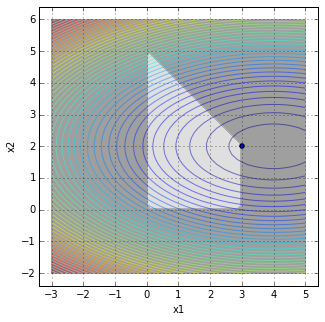

In [21]:
%pylab inline

x1 = linspace(-3, 5, 50)
x2 = linspace(-2, 6, 50)
xx1, xx2 = meshgrid(x1, x2)

f = -8*xx1 - 16*xx2 + xx1**2 + 4*xx2**2
constr1 = (xx1 + xx2 <= 5)
constr2 = (0 <= xx1) & (xx1 <= 3)
constr3 = (xx2 >= 0)

figure(figsize=(5, 5))
grid(True)
xlabel('x1')
ylabel('x2')

contour(x1, x2, f, 50, alpha=0.5)
contourf(x1, x2, constr1 & constr2 & constr3, 1, alpha=0.5, linewidths=4, cmap='gray')
_ = scatter([3], [2])

# Задание 2.

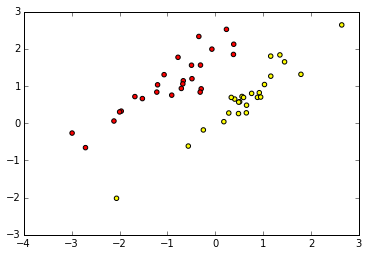

In [59]:
from sklearn.datasets import make_classification
X_lin, y_lin = make_classification(n_samples=50, n_features=2, n_redundant=0, n_clusters_per_class=1, random_state = 1)
y_lin = y_lin.astype(float)
for k in np.nditer(y_lin, op_flags=['readwrite']):
    k[...] = 2 * k - 1
scatter(X_lin[:, 0], X_lin[:, 1], c=y_lin, cmap='autumn')

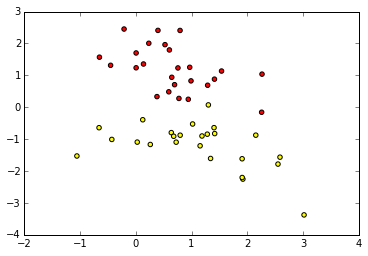

In [60]:
X_notlin, y_notlin = make_classification(n_samples=50, n_features=2, n_redundant=0, n_clusters_per_class=1, random_state = 5)
y_notlin = y_notlin.astype(float)
for k in np.nditer(y_notlin, op_flags=['readwrite']):
    k[...] = 2 * k - 1
scatter(X_notlin[:, 0], X_notlin[:, 1], c=y_notlin, cmap='autumn')

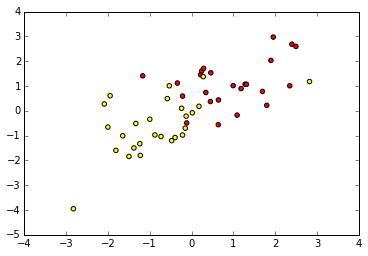

In [62]:
X_bad, y_bad = make_classification(n_samples=50, n_features=2, n_redundant=0, n_clusters_per_class=1, random_state = 7)
y_bad = y_bad.astype(float)
for k in np.nditer(y_bad, op_flags=['readwrite']):
    k[...] = 2 * k - 1
scatter(X_bad[:, 0], X_bad[:, 1], c=y_bad, cmap='autumn')

In [168]:
import itertools
import scipy

def transform(X):
    
    h,w = X.shape
    tX = np.zeros((h, (scipy.special.binom(w,2) + 2 * w)))
    
    for i,k in enumerate(X):
        q = 2
        for j,t in enumerate(k):
            tX[i,j] = X[i,j]
        for c in itertools.combinations_with_replacement(k,2):
            tX[i,q] = np.prod(c)
            q+=1
#    for i,k in enumerate(tX):
#        for c in itertools.combinations_with_replacement(k,2):
#            a = np.prod(c)
#            k = insert(k, a, axis = 1)
    return tX

In [489]:
import itertools
import scipy
import numpy as np
from numpy import linalg
import cvxopt
from cvxopt import matrix
import copy
import cvxopt.solvers
import pylab as plt
from sklearn.cross_validation import train_test_split

class LinSVM():

    def __init__(self, C=1):
        self.C = C
#        if self.C is not None: self.C = float(self.C)

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.bias = 0
        self.weights = np.zeros(n_features)
        
        #все в один вектор длины length
        #веса + ошибки + отступ

        
        #в P зануляем все, кроме весов
        P = spdiag([1.0] * n_features + [0] * (n_samples + 1))
        #в q зануляем, кроме ошибок
        q = matrix([0.0] * n_features + [self.C] * n_samples + [0.0],(n_features + n_samples + 1, 1))
        


        G2 = matrix([[matrix([0] * n_features * n_samples, (n_samples, n_features))], 
                    [spdiag([-1.0] * n_samples)],
                    [matrix([0] * n_samples, (n_samples, 1))]
                    ])
        h2 = matrix([0.0] * n_samples, (n_samples, 1))
 
        tmp = copy.deepcopy(X)
        for i in range(n_samples):
            for j in range(n_features):
                tmp[i][j] *= y[i]

        G11 = matrix(tmp)
        G12 = matrix(y)
        G13 = spdiag([1.] * n_samples)

        G1 = matrix([[G11], [G13], [G12]])
        G1 = -1. * G1
        h1 = matrix([1.0] * n_samples, (n_samples, 1))
        h1 = -1 * h1


        G = matrix([G1, G2])
        h = matrix([h1, h2])
        
        result = solvers.qp(P, q, G, h)
        self.weights = result['x'][:n_features]
        self.epsilons = result['x'][n_features:-2]
        self.bias = result['x'][-1]

    def transform(self, X):
        h,w = X.shape
        tX = np.zeros((h, (scipy.special.binom(w,2) + 2 * w)))      

        for j,t in enumerate(k):
            tX[i,j] = X[i,j]
            for c in itertools.combinations_with_replacement(k,2):
                tX[i,q] = np.prod(c)
                q+=1
        return tX             
            
    def fit_transform(self, X, y=None):
        return self.fit(transform(X),y)

    def predict_proba(self, X):
        result = np.zeros(len(X))
        result = np.dot(X, self.weights) + self.bias
        return result
    
    def predict_proba_tr(self, X):
        trX = transform(X)
        result = np.zeros(len(trX))
        result = np.dot(trX, self.weights) + self.bias
        return result

    def predict(self, X):
        return np.sign(self.predict_proba(X))


In [493]:
def testLin(X,y,C = None, transform = None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
    model = LinSVM(C)
    model.fit(X_train, y_train)
    
    plt.figure(figsize=(5, 5))
    plt.scatter(X[:, 0], X[:, 1.0], c=y, cmap='autumn')

    plt.xvals = np.linspace(-4, 4, 200)
    plt.yvals = np.linspace(-4, 4, 200)

    xx, yy = np.meshgrid(xvals, yvals)
    zz = np.reshape(model.predict_proba(np.c_[xx.ravel(), yy.ravel()]), xx.shape)

    # Цветной фон, соответствующий значению решающего правила
    plt.pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)
    # Опорные вектора
    plt.contour(xx, yy, zz, levels=(1, -1), colors='green', linewidths=1, zorder=1)

    # Линия уровня, соответствующая значению 0.5
    plt.contour(xx, yy, zz, levels=(0,), colors='k', linewidths=1.5, zorder=1)
    plt.xlim([-4, 4])
    plt.ylim([-4, 4])
    #_ = pl.title('KNN Decision Rule')
    plt.show()

In [494]:
def testLinTr(X,y,C = None, transform = None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
    model = LinSVM(C)
    model.fit_transform(X_train, y_train)
    
    plt.figure(figsize=(5, 5))
    plt.scatter(X[:, 0], X[:, 1.0], c=y, cmap='autumn')

    plt.xvals = np.linspace(-4, 4, 200)
    plt.yvals = np.linspace(-4, 4, 200)

    xx, yy = np.meshgrid(xvals, yvals)
    zz = np.reshape(model.predict_proba_tr(np.c_[xx.ravel(), yy.ravel()]), xx.shape)

    # Цветной фон, соответствующий значению решающего правила
    plt.pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)

    plt.contour(xx, yy, zz, levels=(0,), colors='k', linewidths=1.5, zorder=1)
    
    
    plt.xlim([-4, 4])
    plt.ylim([-4, 4])
    #_ = pl.title('KNN Decision Rule')
    plt.show()

### Посмотрим на линейный SVM( без явного преобразования)

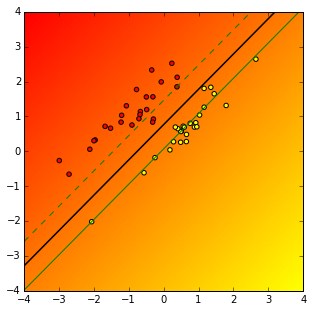

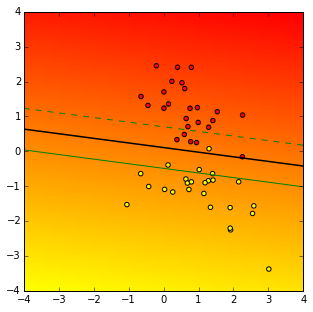

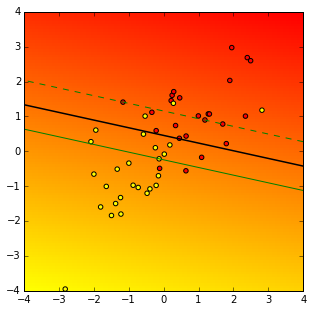

In [485]:
testLin(X_lin, y_lin)
testLin(X_notlin, y_notlin)
testLin(X_bad, y_bad)

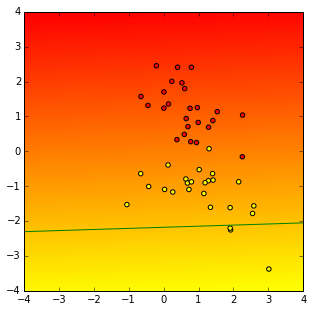

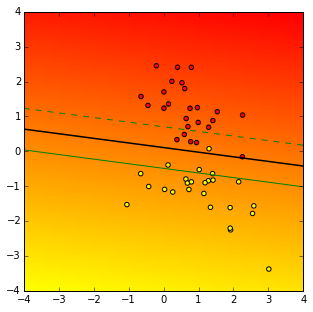

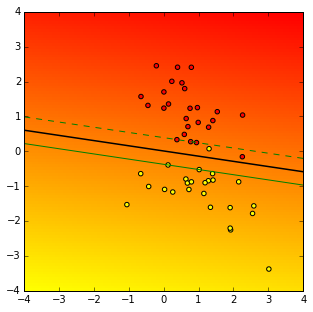

In [492]:
testLin(X_notlin, y_notlin, C = 0.001)
testLin(X_notlin, y_notlin, C = 1)
testLin(X_notlin, y_notlin, C = 1000)

### Линейный SVM с явным преобразованием признаков:

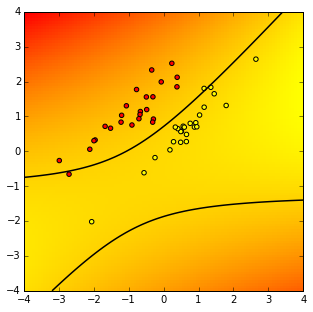

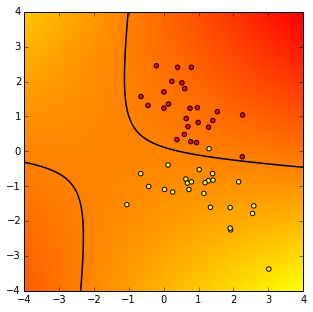

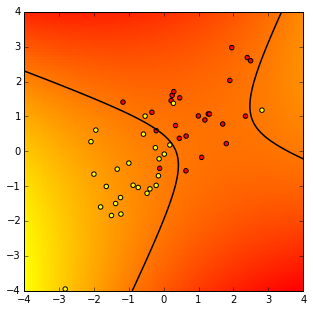

In [478]:
testLinTr(X_lin, y_lin)
testLinTr(X_notlin, y_notlin)
testLinTr(X_bad, y_bad)

# Задание 3.

In [495]:
import itertools
import scipy
import numpy as np
from numpy import linalg
import cvxopt
import cvxopt.solvers
import pylab as pl
from sklearn.cross_validation import train_test_split

def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def polynomial_kernel(x, y, p=3):
    return (1 + np.dot(x, y)) ** p

def gaussian_kernel(x, y, sigma=5.0):
    return np.exp(-linalg.norm(x-y)**2 / (2 * (sigma ** 2)))


class KSVM():

    def __init__(self, C=None, kernel = linear_kernel):
        self.C = C
        self.kernel = kernel
        if self.C is not None: self.C = float(self.C)

    def fit(self, X, y):
        n_samples, n_features = X.shape

        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel(X[i], X[j])

        P = cvxopt.matrix(np.outer(y,y) * K)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        
        #Строим ограничения
        A = cvxopt.matrix(y, (1,n_samples))
        b = cvxopt.matrix(0.0)

        if self.C is None:
            G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            tmp1 = np.diag(np.ones(n_samples) * -1)
            tmp2 = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * self.C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

        solvers.options['show_progress']=False
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)
        lambdas = np.ravel(solution['x'])
        
        # Выбираем опорные
        sup_vec = lambdas > 10e-6
        sup_vec_ind = np.arange(len(lambdas))[sup_vec]
        self.lambdas = lambdas[sup_vec_ind]
        self.sup_vec_x = X[sup_vec_ind]
        self.sup_vec_y = y[sup_vec_ind]

        #Считаем отступ
        self.bias = 0
        for n in range(len(self.lambdas)):
            self.bias += self.sup_vec_y[n] - np.sum(self.lambdas * self.sup_vec_y * K[sup_vec_ind[n],sup_vec_ind])
        self.bias /= len(self.lambdas)

        return self

    def predict_proba(self, X):
        result = np.zeros(len(X))
        for index, vectorX in enumerate(X):
            tmp = 0
            for n in range(len(self.lambdas)):
                tmp += self.lambdas[n] * self.sup_vec_y[n] * self.kernel(self.sup_vec_x[n], vectorX)
            #print(tmp)
            result[index] = tmp
        result = result + self.bias
        return result

    def predict(self, X):
        return np.sign(self.predict_proba(X))

def test(X,y,C = None, kernel=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
    
    model = KSVM( C = C, kernel = kernel)
    model.fit(X_train, y_train)

    pl.figure(figsize=(5, 5))
    pl.scatter(X[:, 0], X[:, 1.0], c=y, cmap='autumn')
    xvals = np.linspace(-4, 4, 200)
    yvals = np.linspace(-4, 4, 200)

    xx, yy = np.meshgrid(xvals, yvals)
    zz = np.reshape(model.predict_proba(np.c_[xx.ravel(), yy.ravel()]), xx.shape)

    # Цветной фон, соответствующий значению решающего правила
    pl.pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)

    # Линия уровня, соответствующая значению 0.5
    pl.contour(xx, yy, zz, levels=(0.,), colors='k', linewidths=1.5, zorder=1)
    plt.contour(xx, yy, zz, levels=(1, -1), colors='green', linewidths=1, zorder=1)

    pl.xlim([-4, 4])
    pl.ylim([-4, 4])
    #_ = pl.title('KNN Decision Rule')
    pl.show()

### посмотрим на линейное ядро:

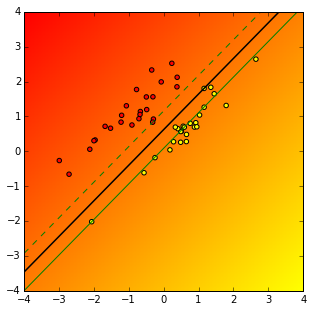

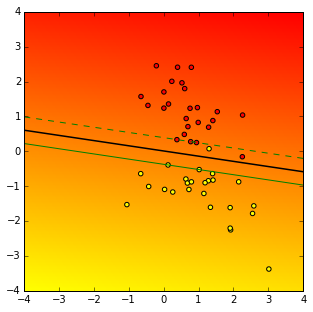

Terminated (singular KKT matrix).


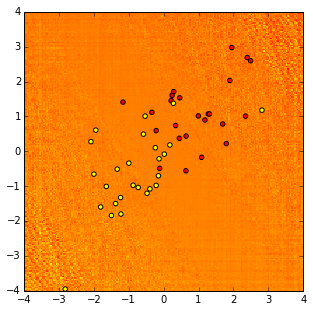

In [496]:
test(X_lin, y_lin, kernel = linear_kernel)
test(X_notlin, y_notlin, kernel = linear_kernel)
test(X_bad, y_bad, kernel = linear_kernel)

### на полиномиальное ядро:

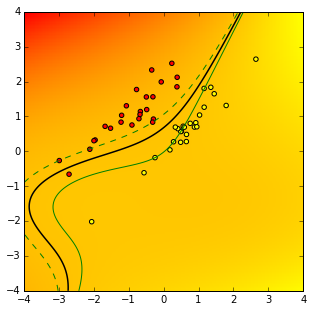

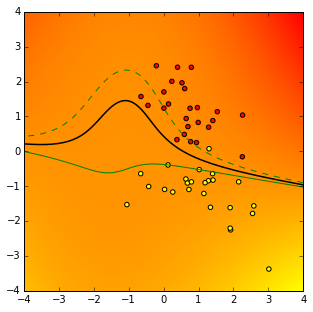

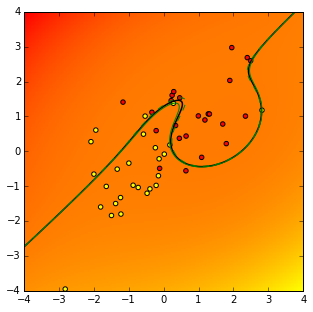

In [497]:
test(X_lin, y_lin, kernel = polynomial_kernel)
test(X_notlin, y_notlin, kernel = polynomial_kernel)
test(X_bad, y_bad, kernel = polynomial_kernel)

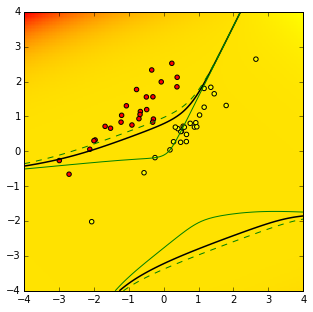

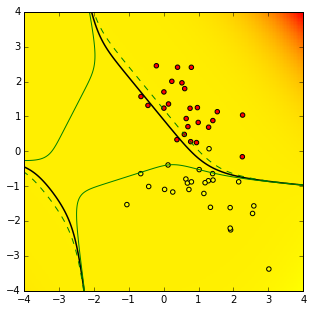

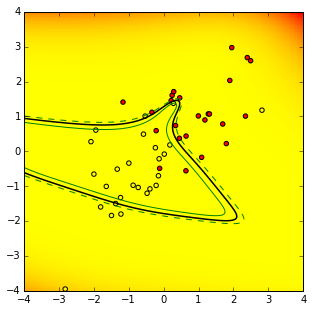

In [498]:
def polynomial_kernel(x, y, p=8):
    return (1 + np.dot(x, y)) ** p
test(X_lin, y_lin, kernel = polynomial_kernel)
test(X_notlin, y_notlin, kernel = polynomial_kernel)
test(X_bad, y_bad, kernel = polynomial_kernel)

### С возрастанием C уменьшается число нарушителей. С возрастанием d делящая гиперплоскость больше подгоняется под обучающую выборку.

### На гассовскую-RBF:

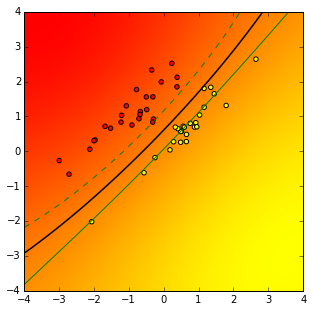

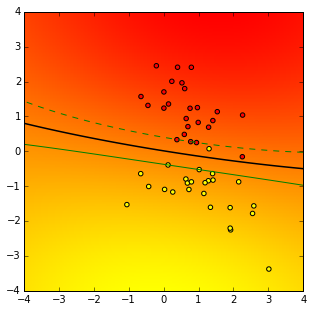

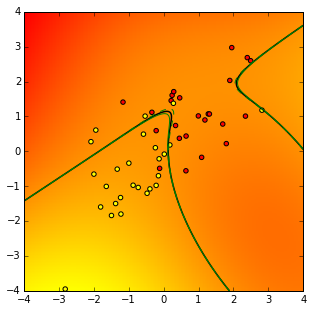

In [499]:
test(X_lin, y_lin, kernel = gaussian_kernel)
test(X_notlin, y_notlin, kernel = gaussian_kernel)
test(X_bad, y_bad, kernel = gaussian_kernel)

### Чем меньше значение параметра сигма, тем сильнее переобучение.

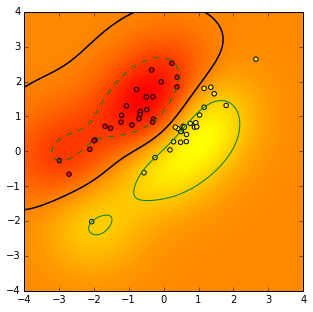

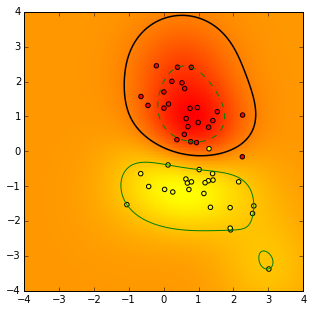

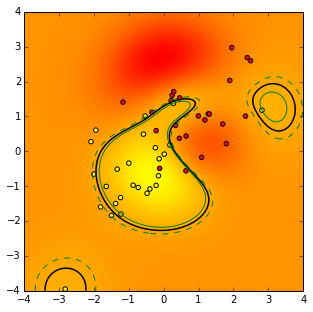

In [500]:
def gaussian_kernel(x, y, sigma=1.0):
    return np.exp(-linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

test(X_lin, y_lin, kernel = gaussian_kernel)
test(X_notlin, y_notlin, kernel = gaussian_kernel)
test(X_bad, y_bad, kernel = gaussian_kernel)